In [11]:
import os
import sys
import time
from datetime import datetime, timedelta
sys.path.insert(0,'..')

from Packages.NoveltyDetection.setup.noveltyDetectionConfig import CONFIG
import numpy as np
from keras.utils import np_utils
import itertools
import multiprocessing
import pprint 

from Packages.NoveltyDetection.NoveltyDetectionAnalysis import NoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

from Functions.telegrambot import Bot

my_bot = Bot("lisa_thebot")

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

training_params = {
    "Technique": "DataVisualization",
    "DevelopmentMode": True,
    "DevelopmentEvents": 100,
    "NoveltyDetection": True,
    "InputDataConfig": {
        "database": "4classes",
        "n_pts_fft": 1024,
        "decimation_rate": 3,
        "spectrum_bins_left": 400,
        "n_windows": 1,
        "balance_data": True
    },
    "HyperParameters": {
        "n_folds": 4,#10, #4,
        "norm": "mapstd",
        "metrics": ["accuracy"],
        "classifier_output_activation_function": "softmax"
    }
}
analysis = NoveltyDetectionAnalysis(parameters=training_params,
                                    model_hash="",
                                    load_hash=False, load_data=True, verbose=True)
all_data, all_trgt, all_trgt_sparse = analysis.getData()

trn_data = {}
trn_trgt = {}
trn_trgt_sparse = {}

for inovelty in range(all_trgt_sparse.shape[1]):
    trn_data[inovelty] = all_data[all_trgt != inovelty]
    trn_trgt[inovelty] = all_trgt[all_trgt != inovelty]
    trn_trgt[inovelty][trn_trgt[inovelty] > inovelty] = trn_trgt[inovelty][trn_trgt[inovelty] > inovelty] - 1
    trn_trgt_sparse[inovelty] = np_utils.to_categorical(trn_trgt[inovelty].astype(int))

[+] Time to read data file: 2.2990894317626953 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
Total of events in the dataset is 77561
Balacing data...
Reading from C:\Users\vinic\Workspace\SonarAnalysis\Results\NoveltyDetection\4_folds_cross_validation_balanced_data_dev.jbl


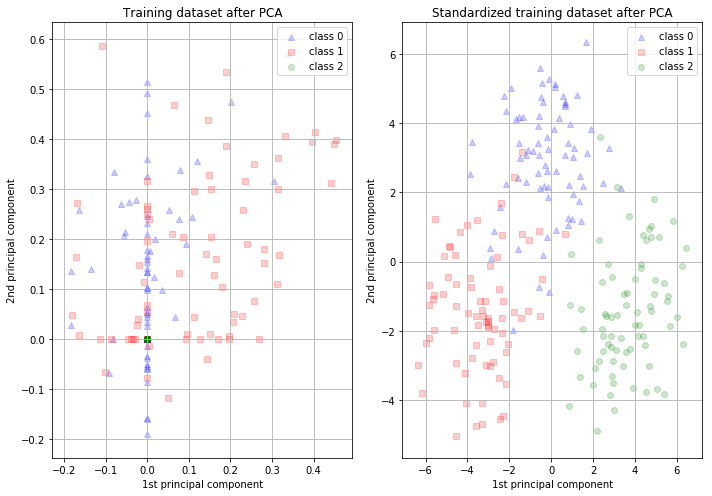

In [12]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

FIG_SIZE = (10, 7)

inovelty = 0
ifold = 0

train_id, test_id = analysis.CVO[inovelty][ifold]

# Make a train/test split using CVO
X_train = trn_data[inovelty][train_id,:]
X_test = trn_data[inovelty][test_id,:]

y_train = trn_trgt[inovelty][train_id]
y_test = trn_trgt[inovelty][test_id]

# Fit to data and predict using PCA.
unscaled_clf = make_pipeline(PCA(n_components=2))
unscaled_clf.fit(X_train, y_train)

# Fit to data using pipelined scaling and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2))
std_clf.fit(X_train, y_train)

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal componenets
# print('\nPC 1 without scaling:\n', pca.components_[0])
# print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Scale and use PCA on X_train data for visualization.
scaler = std_clf.named_steps['standardscaler']
X_train_std = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train[y_train == l, 0], X_train[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.2,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std[y_train == l, 0], X_train_std[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.2,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

In [10]:
all_data.shape

(1600, 400)